# CEO-REQUEST CHALLENGE

> Should Olist remove underperforming sellers from its marketplace?

## Problem statement

To analyse the impact of removing the worse sellers from the marketplace, we can start with a what-if analysis: What would have happened if Olist had never accepted these sellers in the past ? For that:

Step ① Compute, for each `seller_id`, and cumulated since the beginning:
- The `revenues` it brings
- The `costs` associated with all its bad reviews
- The resulting `profits` (revenues - costs)
- The number of `orders` (it will impact overall IT costs)


Step ② We can then sort sellers by increasing profits for Olist, and for each number of seller to remove, compute the financial impact it would have made had they never been accepted on the platform. We may find an optimal number of seller to remove that maximizes Olist's profit margin

In [1]:
# Write down a detailed strategy (steps by step) to create the DataFrame you need for step (1)
# Think about how to re-use or updated what logic you have already coded in your `olist` package

Create a seller DF with the 4 features requested
1. Compute revenues: -> create a series
    composed of:
        cut of 10% of price (or total payment?) -> yes, exludes freight -> alreadt a series
        80 BRL/m/seller -> compute # of month between first and last -> create a series.
2. Costs: composed of:
    star penality -> do a complex aggregate with tailored function
    IT : NOT INCLUDED HERE!
3. Profits : easy substraction
4. Number of orders : already available

<details>
    <summary>Hints</summary>


Starting from your current `seller().get_training_data()` DataFrame:
- Can you easily transform it to compute Olist's positive `revenue_per_seller`? 
- Can you easily transform it to compute Olist's `cost_of_bad_reviews`?

❓Instead of starting again from scratch, investigate in your source code in `seller.py` how was computed the mean `review_score` per seller. Can you imagine a way to ammend your code so as to compute `cost_of_reviews` in the same process ? 
</details>


## Your turn - step 1

### Sellers revenue

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [3]:
from olist.data import Olist
from olist.order import Order
from olist.seller import Seller

In [4]:
sellers = Seller().get_training_data()

In [5]:
sellers.groupby("seller_state").count()

,seller_id,seller_city,delay_to_carrier,wait_time,date_first_sale,date_last_sale,share_one_stars,share_of_five_stars,review_score,n_orders,quantity,sales
seller_state,,,,,,,,,,,,
AM,1,1,1,1,1,1,1,1,1,1,1,1
BA,18,18,18,18,18,18,18,18,18,18,18,18
CE,12,12,12,12,12,12,12,12,12,12,12,12
DF,30,30,30,30,30,30,30,30,30,30,30,30
ES,22,22,22,22,22,22,22,22,22,22,22,22
GO,39,39,39,39,39,39,39,39,39,39,39,39
MA,1,1,1,1,1,1,1,1,1,1,1,1
MG,236,236,236,236,236,236,236,236,236,236,236,236
MS,5,5,5,5,5,5,5,5,5,5,5,5


In [6]:
seller_revenue = sellers[["seller_id", "sales", "date_first_sale", "date_last_sale"]].copy()

seller_revenue.loc[:, "sales_cut"] = seller_revenue["sales"] * 0.1

seller_revenue.loc[:, "months_active"] = \
    (seller_revenue["date_last_sale"] - seller_revenue["date_first_sale"])/np.timedelta64(365,'D')*12

seller_revenue["rounder_active"] = seller_revenue["months_active"].apply(lambda x : int(x)+1 if x>0 else 1)

seller_revenue.loc[:,"revenue"] = seller_revenue["sales_cut"] + 80 * seller_revenue["rounder_active"]

seller_revenue

,seller_id,sales,date_first_sale,date_last_sale,sales_cut,months_active,rounder_active,revenue
0,3442f8959a84dea7ee197c632cb2df15,218.70,2017-05-05 16:25:11,2017-08-30 12:50:19,21.870,3.841670,4,341.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,11703.07,2017-03-29 02:10:34,2018-06-06 20:15:21,1170.307,14.293260,15,2370.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,158.00,2018-07-30 12:44:49,2018-07-30 12:44:49,15.800,0.000000,1,95.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,79.99,2018-08-03 00:44:08,2018-08-03 00:44:08,7.999,0.000000,1,87.999
4,51a04a8a6bdcb23deccc82b0b80742cf,167.99,2017-11-14 12:15:25,2017-11-14 12:15:25,16.799,0.000000,1,96.799
...,...,...,...,...,...,...,...,...
2965,98dddbc4601dd4443ca174359b237166,158.00,2018-07-14 03:10:19,2018-07-23 15:34:03,15.800,0.312871,1,95.800
2966,f8201cab383e484733266d1906e2fdfa,889.00,2017-06-17 15:30:11,2018-08-11 19:55:17,88.900,13.814272,14,1208.900
2967,74871d19219c7d518d0090283e03c137,550.04,2018-04-05 17:09:46,2018-08-21 19:25:15,55.004,4.540080,5,455.004
2968,e603cf3fec55f8697c9059638d6c8eb5,297.00,2017-02-09 02:43:17,2017-06-16 17:30:16,29.700,4.195593,5,429.700


In [93]:
seller_revenue["sales"].sum()*0.1

1356255.223999999

In [95]:
subscription_revenue = seller_revenue["revenue"].sum() - seller_revenue["sales"].sum()*0.1
subscription_revenue

1573600.0

### Seller's cost

In [7]:
matching_table = Olist().get_matching_table()

In [8]:
def cost(x):
    cost = 0
    for score in x:
        if score == 1:
            cost +=100
        if score == 2:
            cost += 50
        if score == 3:
            cost += 40
    return cost

In [12]:
orders_reviews = Order().get_review_score()
matching_table = matching_table[['order_id','seller_id']].drop_duplicates()
seller_cost = matching_table.merge(orders_reviews, on='order_id')

seller_cost = seller_cost.groupby('seller_id',as_index=False).agg({'dim_is_one_star': 'mean',\
                                             'dim_is_five_star': 'mean',\
                                             'review_score': ['mean', cost, 'count']
                                             })
seller_cost.columns = ['seller_id', 'share_one_stars',\
                      'share_of_five_stars', 'review_score', 'review_cost', 'review_count']

In [ ]:
seller_cost

In [ ]:
# df = df.sort_values('review_cost')
# df = df.merge(sellers, on = "seller_id")
# df

### Profit per seller excluding IT

In [64]:
seller_stat = seller_revenue.merge(seller_cost, on = 'seller_id')[["seller_id", "revenue", "review_cost"]]

In [65]:
seller_stat.loc[:, "seller_profit_b4_IT"] = seller_stat["revenue"] - seller_stat["review_cost"]

In [66]:
seller_stat

,seller_id,revenue,review_cost,seller_profit_b4_IT
0,3442f8959a84dea7ee197c632cb2df15,341.870,140,201.870
1,d1b65fc7debc3361ea86b5f14c68d2e2,2370.307,240,2130.307
2,ce3ad9de960102d0677a81f5d0bb7b2d,95.800,0,95.800
3,c0f3eea2e14555b6faeea3dd58c1b1c3,87.999,0,87.999
4,51a04a8a6bdcb23deccc82b0b80742cf,96.799,100,-3.201
...,...,...,...,...
2965,98dddbc4601dd4443ca174359b237166,95.800,0,95.800
2966,f8201cab383e484733266d1906e2fdfa,1208.900,140,1068.900
2967,74871d19219c7d518d0090283e03c137,455.004,0,455.004
2968,e603cf3fec55f8697c9059638d6c8eb5,429.700,50,379.700


### Profit per seller including IT

In [67]:
seller_stat = seller_stat.merge(sellers, on = 'seller_id')[["seller_id", "revenue","review_cost","seller_profit_b4_IT", "n_orders"]]

In [68]:
seller_stat

,seller_id,revenue,review_cost,seller_profit_b4_IT,n_orders
0,3442f8959a84dea7ee197c632cb2df15,341.870,140,201.870,3
1,d1b65fc7debc3361ea86b5f14c68d2e2,2370.307,240,2130.307,40
2,ce3ad9de960102d0677a81f5d0bb7b2d,95.800,0,95.800,1
3,c0f3eea2e14555b6faeea3dd58c1b1c3,87.999,0,87.999,1
4,51a04a8a6bdcb23deccc82b0b80742cf,96.799,100,-3.201,1
...,...,...,...,...,...
2965,98dddbc4601dd4443ca174359b237166,95.800,0,95.800,2
2966,f8201cab383e484733266d1906e2fdfa,1208.900,140,1068.900,10
2967,74871d19219c7d518d0090283e03c137,455.004,0,455.004,6
2968,e603cf3fec55f8697c9059638d6c8eb5,429.700,50,379.700,8


### IT costs per seller

In [69]:
N_orders = matching_table["order_id"].nunique()
cst = 500000/(seller_stat["n_orders"].apply(lambda X:X**0.5).sum())
cst

41.966488604517245

In [70]:
def IT_costs(x):
    return cst * x**0.5

In [71]:
seller_stat.loc[:, "it_cost"] = seller_stat["n_orders"].map(IT_costs)

In [72]:
seller_stat.loc[:, "net_profit"] = seller_stat["seller_profit_b4_IT"] - seller_stat["it_cost"]
seller_stat.sort_values(by = 'net_profit')

,seller_id,revenue,review_cost,seller_profit_b4_IT,n_orders,it_cost,net_profit
769,6560211a19b47992c3666cc44a7e94c0,13850.483,36270,-22419.517,1854,1806.997275,-24226.514275
2360,4a3ca9315b744ce9f8e9374361493884,21647.292,40890,-19242.708,1806,1783.452331,-21026.160331
1358,cc419e0650a3c5ba77189a1882b7556a,11948.842,30000,-18051.158,1706,1733.373474,-19784.531474
946,ea8482cd71df3c1969d7b9473ff13abc,4757.752,20710,-15952.248,1146,1420.675665,-17372.923665
315,8b321bb669392f5163d04c59e235e066,2553.569,15620,-13066.431,943,1288.719735,-14355.150735
...,...,...,...,...,...,...,...
9,ccc4bbb5f32a6ab2b7066a4130f114e3,9000.462,2220,6780.462,187,573.883100,6206.578900
2153,edb1ef5e36e0c8cd84eb3c9b003e486d,8808.455,1520,7288.455,166,540.700382,6747.754618
534,fa1c13f2614d7b5c4749cbc52fecda94,21004.203,6750,14254.203,585,1015.033944,13239.169056
67,7e93a43ef30c4f03f38b393420bc753a,19403.187,4800,14603.187,336,769.258443,13833.928557


In [92]:
display(f"net profit: {seller_stat['net_profit'].sum()}")
display(f"review cost: {seller_stat['review_cost'].sum()}")
display(f"revenue: {seller_stat['revenue'].sum()}")
display(f"orders: {seller_stat['n_orders'].sum()}")

'net profit: 760325.223999999'

'review cost: 1669530'

'revenue: 2929855.223999999'

'orders: 99844'

### Extra analyses on products

In [74]:
matching_table = Olist().get_matching_table()

products = Olist().get_data()["products"]


In [121]:
from olist.product import Product
product_data = Product().get_training_data().copy()

from olist.product_solution import ProductSol
product_data_sol = ProductSol().get_training_data().copy()

In [125]:
product_data.sort_values(by='review_cost')

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category,wait_time,share_of_one_stars,share_of_five_stars,review_score,review_cost,n_orders,quantity,mean_price
0,1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,perfumery,3.017639,0.000000,1.000000,5.000000,0,1,1,10.910000
19063,0b37bd7d994d4ab29992281e2690ad1a,35.0,804.0,1.0,431.0,18.0,18.0,15.0,health_beauty,8.666875,0.000000,1.000000,5.000000,0,1,1,66.710000
19062,e892e0e01990e737eb81a57db12f8c8c,53.0,377.0,1.0,325.0,16.0,14.0,15.0,health_beauty,17.098981,0.000000,1.000000,5.000000,0,1,1,39.890000
19060,8a4505505378c8f5d983f3201e9c25da,47.0,1400.0,1.0,325.0,19.0,20.0,18.0,health_beauty,12.735286,0.000000,1.000000,5.000000,0,4,4,83.400000
19057,188372a703d9a84ec0b6a32a0044c7f2,32.0,3834.0,1.0,150.0,16.0,9.0,11.0,health_beauty,14.833866,0.000000,1.000000,5.000000,0,1,1,49.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17170,7c1bd920dbdf22470b68bde975dd3ccf,59.0,492.0,2.0,200.0,22.0,10.0,18.0,health_beauty,11.047993,0.158798,0.523605,3.854077,2630,225,239,60.028961
20004,422879e10f46682990de24d770e7f83d,56.0,348.0,2.0,1550.0,30.0,22.0,30.0,garden_tools,15.878756,0.118644,0.601695,4.118644,2835,352,487,54.911612
20394,53759a2ecddad2bb87a079a1f1519f73,58.0,340.0,2.0,1500.0,30.0,22.0,30.0,garden_tools,15.765851,0.152249,0.577855,3.972318,2910,287,375,54.657373
8988,aca2eb7d00ea1a7b8ebd4e68314663af,44.0,903.0,6.0,2600.0,50.0,10.0,30.0,furniture_decor,11.820620,0.083527,0.531323,4.092807,3165,431,527,71.364137


In [188]:
n_quantity = product_data['quantity'].sum()

In [126]:
product_data.loc[:, "sales_cut"] = product_data["mean_price"] * product_data["quantity"] * 0.1

In [127]:
product_data.sort_values(by ='sales_cut')

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category,wait_time,share_of_one_stars,share_of_five_stars,review_score,review_cost,n_orders,quantity,mean_price,sales_cut
17715,46fce52cef5caa7cc225a5531c946c8b,48.0,398.0,2.0,54.0,22.0,2.0,15.0,health_beauty,3.874201,0.000000,1.000000,5.000000,0,1,1,2.200000,0.220000
24553,310dc32058903b6416c71faff132df9e,36.0,326.0,1.0,300.0,16.0,10.0,11.0,stationery,4.978322,0.000000,1.000000,5.000000,0,1,1,2.290000,0.229000
27682,8a3254bee785a526d548a81a9bc3c9be,25.0,1041.0,5.0,200.0,16.0,4.0,11.0,construction_tools_construction,10.546883,0.333333,0.333333,3.333333,50,3,3,0.850000,0.255000
28473,680cc8535be7cc69544238c1d6a83fe8,48.0,1392.0,1.0,200.0,16.0,2.0,11.0,pet_shop,11.165810,0.000000,1.000000,5.000000,0,1,1,2.900000,0.290000
25159,2e8316b31db34314f393806fd7b6e185,55.0,88.0,1.0,100.0,16.0,10.0,16.0,stationery,14.720162,0.000000,1.000000,5.000000,0,1,1,2.990000,0.299000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13163,99a4788cb24856965c36a24e339b6058,54.0,245.0,1.0,1383.0,50.0,10.0,40.0,bed_bath_table,13.519772,0.134043,0.482979,3.865957,4900,467,491,88.167131,4329.006139
15763,d1c427060a0f73f6b889a5c7c61f2ac4,59.0,1893.0,1.0,6550.0,20.0,20.0,20.0,computers_accessories,13.316342,0.105263,0.609907,4.213622,2175,323,343,137.651633,4721.451000
26056,d6160fb7873f184099d9bc95e30376af,55.0,3632.0,4.0,2600.0,16.0,31.0,39.0,computers,12.077439,0.057143,0.800000,4.571429,125,35,35,1397.124000,4889.934000
18313,6cdd53843498f92890544667809f1595,51.0,625.0,1.0,900.0,25.0,12.0,38.0,health_beauty,15.436376,0.079470,0.668874,4.324503,845,151,156,350.834615,5473.020000


In [128]:
product_data["sales_cut"].sum() #CHECK OK

1330149.7532422096

In [129]:
product_data["review_cost"].sum() #CHECK HALF OF BEFORE OK

831035

In [130]:
product_data.loc[:, "profit_b4_it"] = product_data["sales_cut"]- product_data["review_cost"]

product_data.loc[:, "it_cost"] = product_data["n_orders"].map(IT_costs)
product_data["it_cost_revised"] = product_data["it_cost"]/4

In [135]:
product_data.loc[:, "net_profit"] = product_data["sales_cut"]- product_data["review_cost"] - product_data["it_cost_revised"]

product_profit = product_data[["product_id", "category","review_score", 'review_cost', "net_profit", "mean_price", "quantity"]].sort_values(by = "net_profit")

product_profit.loc[:, "net_profit_per_item"] =\
    product_data["net_profit"]/product_data["quantity"]

product_profit.loc[:, "net_profit_withsubs"] =\
    product_data["net_profit"] + subscription_revenue/n_quantity*product_data["quantity"]

In [263]:
product_data.sort_values(by = 'net_profit').head(20)

,product_id,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,category,wait_time,...,review_cost,n_orders,quantity,mean_price,sales_cut,profit_b4_it,it_cost,it_cost_revised,net_profit,net_profit_per_item
16618,89b121bee266dcd25688a1ba72eefb61,54.0,1169.0,1.0,150.0,16.0,16.0,16.0,computers_accessories,12.263175,...,1945,62,68,79.900000,543.320000,-1401.680000,330.444462,82.611115,-1484.291115,-21.827811
17170,7c1bd920dbdf22470b68bde975dd3ccf,59.0,492.0,2.0,200.0,22.0,10.0,18.0,health_beauty,11.047993,...,2630,225,239,60.028961,1434.692169,-1195.307831,629.497329,157.374332,-1352.682163,-5.659758
11239,b5e13c9a353102f79c6206ff5cb61a50,59.0,249.0,2.0,1500.0,40.0,25.0,20.0,toys,17.192536,...,1845,83,91,85.834066,781.090000,-1063.910000,382.332907,95.583227,-1159.493227,-12.741684
16394,e53e557d5a159f5aa2c5e995dfdf244b,33.0,256.0,1.0,180.0,17.0,10.0,13.0,computers_accessories,18.693102,...,2610,156,188,84.367486,1586.108743,-1023.891257,524.161275,131.040319,-1154.931575,-6.143253
17077,154e7e31ebfa092203795c972e5804a6,48.0,575.0,1.0,100.0,20.0,15.0,15.0,health_beauty,9.891702,...,1580,269,293,22.509573,659.530488,-920.469512,688.301590,172.075397,-1092.544910,-3.728822
20394,53759a2ecddad2bb87a079a1f1519f73,58.0,340.0,2.0,1500.0,30.0,22.0,30.0,garden_tools,15.765851,...,2910,287,375,54.657373,2049.651475,-860.348525,710.957403,177.739351,-1038.087876,-2.768234
14265,84f456958365164420cfc80fbe4c7fab,55.0,312.0,1.0,1550.0,44.0,14.0,34.0,bed_bath_table,14.618981,...,1870,106,111,92.837477,1030.496000,-839.504000,432.071445,108.017861,-947.521861,-8.536233
15582,cd46a885543f0e169a49f1eb25c04e43,58.0,1390.0,2.0,3475.0,54.0,13.0,48.0,computers_accessories,17.952105,...,1145,28,30,99.990000,299.970000,-845.030000,222.065784,55.516446,-900.546446,-30.018215
22916,7ce94ab189134e2d3c05f496d635419c,39.0,400.0,1.0,200.0,25.0,7.0,16.0,electronics,15.925086,...,925,104,106,13.650000,144.690000,-780.310000,427.975889,106.993972,-887.303972,-8.370792
13163,99a4788cb24856965c36a24e339b6058,54.0,245.0,1.0,1383.0,50.0,10.0,40.0,bed_bath_table,13.519772,...,4900,467,491,88.167131,4329.006139,-570.993861,906.903490,226.725872,-797.719733,-1.624684


### Plots

<AxesSubplot:xlabel='review_score', ylabel='net_profit'>

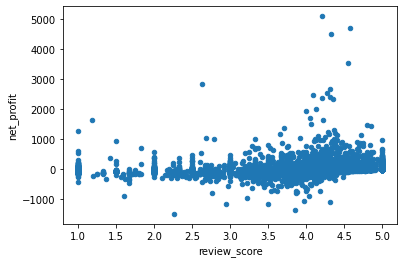

In [141]:
product_profit.plot( x='review_score', y='net_profit', kind = 'scatter')

<AxesSubplot:xlabel='review_score', ylabel='net_profit_per_item'>

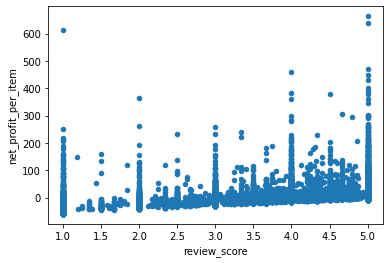

In [149]:
product_profit.plot( x='review_score', y='net_profit_per_item', kind = 'scatter')

<AxesSubplot:xlabel='net_profit_per_item', ylabel='net_profit'>

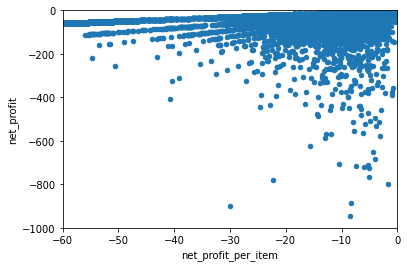

In [153]:
product_profit.plot( x='net_profit_per_item', y='net_profit', kind = 'scatter', ylim=(-1000,0), xlim=(-60,0))

<AxesSubplot:xlabel='review_score', ylabel='mean_price'>

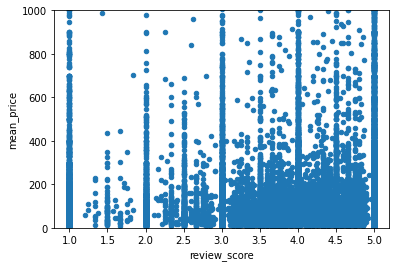

In [176]:
product_profit.plot( x='review_score', y='mean_price', kind = 'scatter', ylim=(0,1000))

In [198]:
by_cat = product_profit.groupby('category', as_index=False).agg({\
  'net_profit':'sum', 'net_profit_per_item':'mean','quantity':'sum',\
    'review_score':'mean', 'mean_price':'mean', 'review_cost':'sum', 'net_profit_withsubs':'sum'                                        
})

In [199]:
by_cat = by_cat.sort_values(by='net_profit')
by_cat.head(10)

,category,net_profit,net_profit_per_item,quantity,review_score,mean_price,review_cost,net_profit_withsubs
7,bed_bath_table,-48152.977586,-7.190649,11229,3.875182,107.595206,105255,111323.145158
39,furniture_decor,-28506.395120,-6.595365,8330,3.949255,102.963274,63885,89797.648201
68,telephony,-25864.267199,-8.335888,4527,3.992404,82.022670,38540,38428.938578
49,housewares,-16807.741220,-5.251112,6906,4.119339,97.908845,45720,81272.417625
26,electronics,-14467.243903,-4.301460,2754,4.118102,97.926903,20280,24645.521440
28,fashion_bags_accessories,-10584.603134,-7.544137,2030,4.151389,85.684496,14195,18245.793978
66,stationery,-5194.109477,-3.927812,2507,4.270435,101.114669,15130,30410.720847
65,sports_leisure,-3339.490861,-1.619017,8645,4.156074,134.365843,58825,119438.234771
44,home_appliances,-2481.291789,-6.195693,803,4.162191,99.448300,5725,8923.047562
69,toys,-1793.437568,-1.944829,4083,4.210740,132.404454,28660,56194.006476


In [185]:
by_cat = by_cat.sort_values(by='net_profit')
by_cat.tail(10)

,category,net_profit,net_profit_per_item,quantity,review_score,mean_price,review_cost
57,office_furniture,4426.941729,3.757717,1691,3.743929,206.582984,17335
0,agro_industry_and_commerce,4807.987462,28.175148,209,3.924322,441.921263,1310
45,home_appliances_2,8161.623330,32.860939,239,3.985246,492.478553,1615
42,garden_tools,8664.611800,7.456465,4326,4.176015,220.965915,27465
56,musical_instruments,10304.538616,16.717579,664,4.148550,327.699729,4310
63,small_appliances,10776.661010,20.199578,672,4.174838,348.810033,4490
14,computers,20236.540587,123.087924,203,4.034527,1368.067042,1400
43,health_beauty,20717.467887,0.080258,9672,4.226325,147.118205,66440
20,cool_stuff,22544.431967,6.718639,3781,4.178762,212.033235,25970
70,watches_gifts,46602.008114,18.103522,5970,4.213550,332.170080,50495


In [258]:
by_cat = by_cat.sort_values(by='net_profit')
by_cat.head(20)

,category,net_profit,net_profit_per_item,quantity,review_score,mean_price,review_cost,net_profit_withsubs
7,bed_bath_table,-48152.977586,-7.190649,11229,3.875182,107.595206,105255,111323.145158
39,furniture_decor,-28506.395120,-6.595365,8330,3.949255,102.963274,63885,89797.648201
68,telephony,-25864.267199,-8.335888,4527,3.992404,82.022670,38540,38428.938578
49,housewares,-16807.741220,-5.251112,6906,4.119339,97.908845,45720,81272.417625
26,electronics,-14467.243903,-4.301460,2754,4.118102,97.926903,20280,24645.521440
28,fashion_bags_accessories,-10584.603134,-7.544137,2030,4.151389,85.684496,14195,18245.793978
66,stationery,-5194.109477,-3.927812,2507,4.270435,101.114669,15130,30410.720847
65,sports_leisure,-3339.490861,-1.619017,8645,4.156074,134.365843,58825,119438.234771
44,home_appliances,-2481.291789,-6.195693,803,4.162191,99.448300,5725,8923.047562
69,toys,-1793.437568,-1.944829,4083,4.210740,132.404454,28660,56194.006476


In [260]:
by_cat = by_cat.sort_values(by='net_profit')
by_cat.head(20)

,category,net_profit,net_profit_per_item,quantity,review_score,mean_price,review_cost,net_profit_withsubs
7,bed_bath_table,-48152.977586,-7.190649,11229,3.875182,107.595206,105255,111323.145158
39,furniture_decor,-28506.395120,-6.595365,8330,3.949255,102.963274,63885,89797.648201
68,telephony,-25864.267199,-8.335888,4527,3.992404,82.022670,38540,38428.938578
49,housewares,-16807.741220,-5.251112,6906,4.119339,97.908845,45720,81272.417625
26,electronics,-14467.243903,-4.301460,2754,4.118102,97.926903,20280,24645.521440
28,fashion_bags_accessories,-10584.603134,-7.544137,2030,4.151389,85.684496,14195,18245.793978
66,stationery,-5194.109477,-3.927812,2507,4.270435,101.114669,15130,30410.720847
65,sports_leisure,-3339.490861,-1.619017,8645,4.156074,134.365843,58825,119438.234771
44,home_appliances,-2481.291789,-6.195693,803,4.162191,99.448300,5725,8923.047562
69,toys,-1793.437568,-1.944829,4083,4.210740,132.404454,28660,56194.006476


<AxesSubplot:xlabel='category', ylabel='net_profit'>

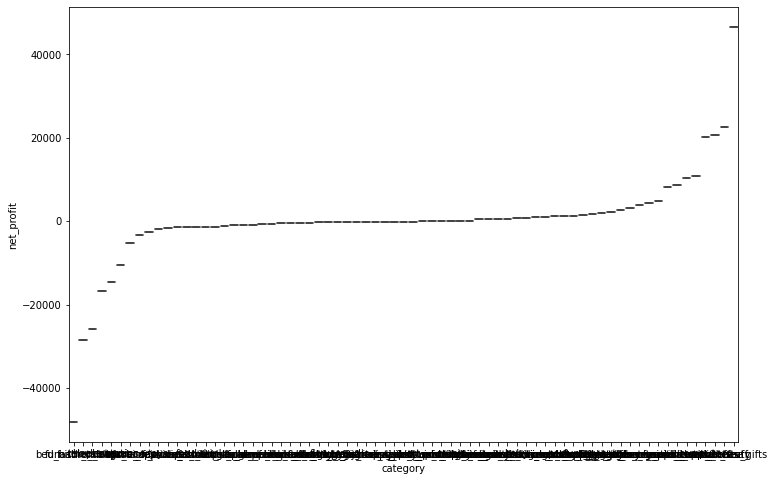

In [166]:
fig, ax1 = plt.subplots(1,1, figsize = (12,8))
sns.boxplot( x='category', y = 'net_profit', data = by_cat, ax = ax1)

## Your turn - step 2 (sorting through sellers)

function that computes profit when removing n worst sellers, constant alpha (IT cost coef)

In [204]:
seller_stat.loc[:, "cut "] = seller_stat["seller_profit"] - seller_stat["it_cost"]

KeyError: 'seller_profit'

In [ ]:
def cut_losses(n):
    return seller_stat["net_profit"][n:].sum()

In [ ]:
x = np.linspace(0, 1000, 100)
# y = [cut_losses(i) for i in x]
y =[cut_losses(int(i)) for i in x]

In [ ]:
plt.plot(x , y)

In [ ]:
cutting_losses = seller_stat[seller_stat["net_profit"] > 0]["net_profit"].sum() - seller_stat["net_profit"].sum()
cutting_losses

In [ ]:
seller_stat["profit_per_order"].plot(kind = 'hist', label = 'profit per order', xlim = (-100,300), bins = 100)
plt.legend()

In [ ]:
seller_stat.plot( x = 'n_orders', y='profit_per_order', kind = 'scatter')

In [234]:
total_seller = seller_stat.merge(sellers, on = "seller_id").merge(seller_revenue,on = "seller_id")
total_seller.columns

Index(['seller_id', 'revenue_x', 'review_cost', 'seller_profit_b4_IT',
       'n_orders_x', 'it_cost', 'net_profit', 'seller_city', 'seller_state',
       'delay_to_carrier', 'wait_time', 'date_first_sale_x',
       'date_last_sale_x', 'share_one_stars', 'share_of_five_stars',
       'review_score', 'n_orders_y', 'quantity', 'sales_x', 'sales_y',
       'date_first_sale_y', 'date_last_sale_y', 'sales_cut', 'months_active',
       'rounder_active', 'revenue_y'],
      dtype='object')

In [235]:
total_seller.loc[:, "mean_price"] = total_seller["sales_x"]/total_seller["quantity"]

In [ ]:
total_seller.plot( x = 'months_active', y='net_profit', kind = 'scatter', ylim = (-1000,1000))

In [207]:
tmp = seller_stat.merge(sellers, on = "seller_id")
tmp.columns

Index(['seller_id', 'revenue', 'review_cost', 'seller_profit_b4_IT',
       'n_orders_x', 'it_cost', 'net_profit', 'seller_city', 'seller_state',
       'delay_to_carrier', 'wait_time', 'date_first_sale', 'date_last_sale',
       'share_one_stars', 'share_of_five_stars', 'review_score', 'n_orders_y',
       'quantity', 'sales'],
      dtype='object')

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize = (12,6))
sns.stripplot( x='seller_state', y = 'net_profit', hue = 'review_score', data = tmp, ax = ax1)

In [ ]:
fig, ax1 = plt.subplots(1,1, figsize = (12,8))
sns.boxplot( x='seller_state', y = 'net_profit', data = tmp, ax = ax1)

In [225]:
tmp.sort_values(by='net_profit').head(20)

,seller_id,revenue,review_cost,seller_profit_b4_IT,n_orders_x,it_cost,net_profit,seller_city,seller_state,delay_to_carrier,wait_time,date_first_sale,date_last_sale,share_one_stars,share_of_five_stars,review_score,n_orders_y,quantity,sales
769,6560211a19b47992c3666cc44a7e94c0,13850.483,36270,-22419.517,1854,1806.997275,-24226.514275,sao paulo,SP,0.000000,9.539486,2017-02-17 07:45:11,2018-08-29 09:25:12,0.127957,0.510215,3.922043,1854,2039,123304.83
2360,4a3ca9315b744ce9f8e9374361493884,21647.292,40890,-19242.708,1806,1783.452331,-21026.160331,ibitinga,SP,0.000000,14.416471,2017-01-08 09:45:12,2018-08-27 11:04:18,0.147640,0.476948,3.804610,1806,2009,200472.92
1358,cc419e0650a3c5ba77189a1882b7556a,11948.842,30000,-18051.158,1706,1733.373474,-19784.531474,santo andre,SP,0.000000,11.539753,2017-02-02 17:10:21,2018-08-28 03:45:15,0.117277,0.581808,4.069222,1706,1819,104288.42
946,ea8482cd71df3c1969d7b9473ff13abc,4757.752,20710,-15952.248,1146,1420.675665,-17372.923665,sao paulo,SP,0.000000,13.315562,2017-08-16 15:15:26,2018-08-25 02:45:21,0.116827,0.524847,3.984307,1146,1204,37177.52
315,8b321bb669392f5163d04c59e235e066,2553.569,15620,-13066.431,943,1288.719735,-14355.150735,sao paulo,SP,0.000000,12.616899,2017-10-27 16:31:30,2018-08-21 17:08:38,0.118770,0.567338,4.069989,943,1018,17535.69
453,1f50f920176fa81dab994f9023523100,12053.921,22270,-10216.079,1404,1572.483824,-11788.562824,sao jose do rio preto,SP,0.000000,15.571831,2017-04-03 22:15:14,2018-08-28 03:45:18,0.113556,0.598297,4.123492,1404,1940,106939.21
1214,d2374cbcbb3ca4ab1086534108cc3ab7,3642.392,13070,-9427.608,524,960.656833,-10388.264833,ibitinga,SP,0.000000,14.297115,2017-02-10 15:50:20,2018-08-22 04:04:20,0.155844,0.454545,3.727273,524,658,21223.92
1133,7c67e1448b00f6e969d365cea6b010ab,20312.389,28530,-8217.611,982,1315.098785,-9532.709785,itaquaquecetuba,SP,0.000000,22.392546,2017-01-26 22:55:10,2018-08-08 03:10:34,0.200405,0.350202,3.484818,982,1375,187923.89
2025,cca3071e3e9bb7d12640c9fbe2301306,8240.989,16490,-8249.011,712,1119.805586,-9368.816586,ibitinga,SP,0.000000,14.242646,2016-10-04 10:28:07,2018-08-22 23:05:18,0.153846,0.497253,3.811813,712,849,64009.89
2689,1835b56ce799e6a4dc4eddc053f04066,4294.421,11730,-7435.579,423,863.123252,-8298.702252,ibitinga,SP,0.000000,12.770314,2017-09-05 23:15:10,2018-08-25 16:50:21,0.211765,0.444706,3.618824,423,560,33344.21


In [228]:
display(tmp.sort_values(by='net_profit').head(20)["net_profit"].sum())
display(tmp.sort_values(by='net_profit').head(20)["n_orders_x"].sum())

-202740.61646409347

16624

**Votre requête**: 

*Exploiter la richesse de la base de données Ollist pour effectuer des recommandations:
Comment améliorer votre business et vos profits?*

Nous estimons le coût des revues négatives à **800K BR** pour Ollist depuis ses débuts.

Cela réduit a réduit votre marge de profit d'un potentiel de 1,5M BR à 700K BR.

Avec notre proposition, vous pourrez augmenter votre profit de **30%, soit 200K BR**.

Notre proposition est de **bloquer l'accès à votre plateforme pour 20 vendeurs.**

Ils sont responsables de **25% de vos revues négatives**, et apportent un revenu limité en raison du **faible prix moyen de leurs ventes**.

Le trade-off sera de réduire le nombre de ventes de la plateforme d'environ 15%, ainsi que la réaction de ces vendeurs.

<AxesSubplot:xlabel='review_score', ylabel='net_profit'>

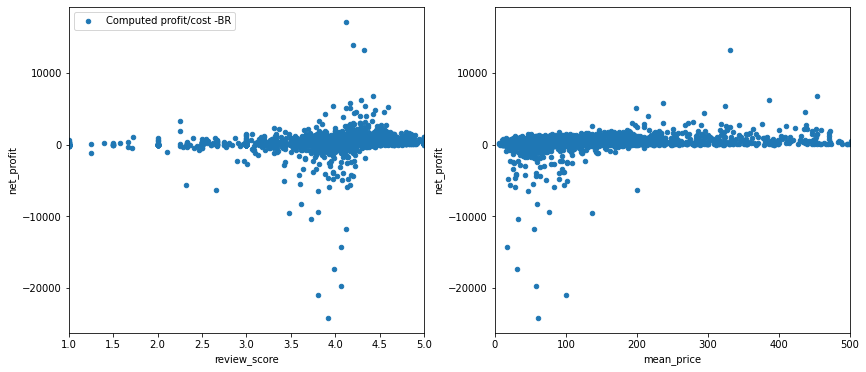

In [271]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,6))
total_seller.plot( x = 'mean_price', y='net_profit', kind = 'scatter', xlim = (0,500), ax=ax2)
total_seller.plot( x = 'review_score', y='net_profit', kind = 'scatter', xlim = (1,5), ax=ax1)

In [252]:
worst = by_cat.head(10)
best = by_cat.tail(10)

**Types de produits:**
Notre analyse par catégorie de produits montre que certains catégories sous-performent:
1. Accessoires/Meubles de chambre et salle de bain
1. Meubles
1. Equipement électroménager

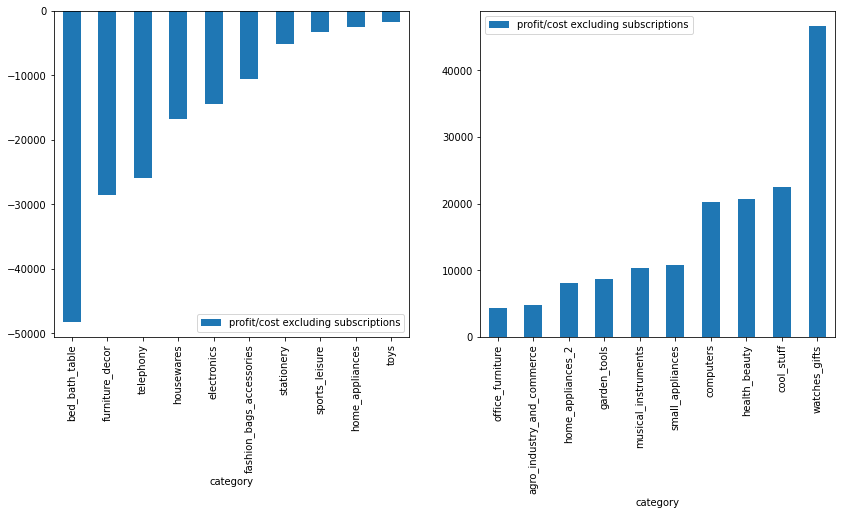

In [257]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (14,6))
worst.plot( x = 'category', y='net_profit', kind = 'bar', ax=ax1, label = 'profit/cost excluding subscriptions')
best.plot( x = 'category', y='net_profit', kind = 'bar', ax=ax2, label = 'profit/cost excluding subscriptions')
plt.legend()

Cepedant, éliminer ces catégories entraînerait une perte de revenu d'abonnement mensuel significative.
Notre recommendation est donc de **ne pas** les eliminer.

Une action judicieuse serait de communiquer vis à vis des acheteurs pour leur préciser que les **délais d'acheminement peuvent être plus long pour ces équipements.**

Cela permettrait de réduire la proportion de revues négatives pour ces ventes.